# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Plan" data-toc-modified-id="Plan-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Plan</a></div><div class="lev2 toc-item"><a href="#Classes" data-toc-modified-id="Classes-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Classes</a></div><div class="lev2 toc-item"><a href="#Tests" data-toc-modified-id="Tests-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Tests</a></div>

## Plan
* Sit for 3 hours and finish it. Rest will happen automatically. 
* Function call flow:
* x -> x_down -> y_loc, y_class -> pred_loc, pred_class -> loss_class, loss_reg -> loss
* This completes the feedback loop.

## Classes
The following classes/methods exist in the dataset
* downsample
* encode
* Network
* Loss

In [1]:
import numpy as np
from network import VGGNet


def encode_y(x_down, labels_down):
    """
    x_downsampled tensor -> y_tensor: Numpy
    
    Args:
        x_down (b, 3, 60, 60): Downsampled list of images
        labels_down (b, v, 2): List of lists of lists (downsampled boxes)
        
    Returns:
        y_class (b, 1, 60, 60): Tensor containing mask for each image. Calculated within encode
        y_loc (b, 4, 60, 60):
    """
    
    y_class = np.zeros((x_down.shape[0], x_down.shape[2], x_down.shape[3]))
    y_loc = np.zeros((x_down.shape[0], 4, x_down.shape[2], x_down.shape[3]))
    
    y_class[x_down[:,0,:,:]>0] = 1 # Can also choose a smaller neighbourhood here
    pos_inds = np.argwhere(y_class) # y_class is also the positive examples mask
    
    for b, y, x in pos_inds:
        y_loc[b, :, y, x] = match_boxes(x, y, labels_down[b])
        
    y_class = y_class.reshape(x_down.shape[0], 1, x_down.shape[2], x_down.shape[3])
    
    return y_class, y_loc

def match_boxes(x, y, boxes):
    """ Numpy
    Matches a point (x,y) to a bunch of boxes. Returns offset of the box with the nearest centre.
    
    Args:
        x (scalar): X coordinate of point being matched
        y (scalar): Y coordinate of point being matched
        boxes: List of list of downsampled boxes being matched, in (tx, ty, bx, by) notation
    
    """
    
    dist = 10**5 # Store the smallest disance to a large no initially, can glitch if dist greater than this
    
    for box in boxes:
        cx = (box[0] + box[2])/2
        cy = (box[1] + box[3])/2
        
        box_dist = (cx - x)**2 + (cy - y)**2
        
        if box_dist < dist:
            offset = np.array([box[0] - x, box[1] - y, box[2] - x, box[3] - y])
            dist = box_dist
            
    # Should not glitch because matching is only done for positive indices
    return offset
    

def downsample(x, labels):
    """
    x -> x/4
    
    Args:
        x (b, 3, 240, 240): Batch of 3 channel 240 x 240 images
        labels (b, v, 4): List of list of boxes

    Returns:
        x_down (b, 3, 60, 60): Batch of 3 channel 60x60 images
        labels_down (b, v, 4): List of list of downsampled boxes
    """
    # Resize batch by two max pools
    x_down = F.max_pooling_2d(F.max_pooling_2d(x, 2, stride=2 ), 2, stride=2 ) # Is this correct? Should we use bilinear interpolation instead?
    labels_down = np.asarray(labels)/4.0
    labels = np.divide(np.asarray(labels), 4.0)
    return x_down.data, labels_down

def loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4):
    """
    Calculates weighted sum of classification and regression loss. Calls the classification loss and regression loss functions separately.
    
    Args:
        pred_class (b, 1, 60, 60): Network confidence probs for images
        pred_loc (b, 4, 60, 60): Network offsets for each location
        gt_class (b, 1, 60, 60): Gt class scores from encode
        gt_loc (b, 4, 60, 60): Gt regression offsets from encode
        lambd (scalar): WEighting factor comparison regression loss to 
        
    Returns:
        loss: Scalar value of 
    """
    return classification_loss(pred_class, gt_class) + lambd * regression_loss(pred_loc, gt_loc, gt_class)

def classification_loss(pred_class, gt_class, debug=False):
    """
    Classification loss from mean squared diff between probabilities. Should probably use cross entropy instead but usng this now for simplicity.
    
    Also does hard negative mining. so requires generation of a selction mask of positives and most overconfident negatives.
    
    Args:
        pred_class (b, 1, 60, 60): Network confidence probs
        gt_class (b, 1, 60, 60): Binary gt confidence probs
        
    Returns:
        class_loss: Scalar
    """
    abs_loss = (pred_class - gt_class) ** 2
    mask = selection_mask(abs_loss.data, gt_class)
    selected_loss = abs_loss * mask
    
    if debug:
        return selected_loss/pred_class.shape[0]
    else:
        return F.sum(selected_loss)/pred_class.shape[0]

def regression_loss(pred_loc, gt_loc, gt_class, debug=False):
    """
    Regression loss from vanilla mean squared diff between shifts.
    
    Args:
        pred_loc (b, 4, 60, 60): Network offsets for top left and bottom right of box. Should 
        gt_loc (b, 4, 60, 60): Ground truth offsets for top left and bottom right of box.  
        gt_class (b, 1, 60, 60): Offsets for positive examples
        
    Returns:
        reg_loss: Scalar
    """
    abs_loss = F.sum(((pred_loc - gt_loc) ** 2),axis=1) # Check dims in test
    abs_loss = F.reshape(abs_loss,(abs_loss.shape[0],1,abs_loss.shape[1], abs_loss.shape[2]))

    selected_loss = abs_loss * gt_class
    
    if debug:
        return selected_loss/pred_loc.shape[0]
    else:
        return F.sum(selected_loss)/pred_loc.shape[0]

def selection_mask(abs_loss, gt_class):
    """ Is there a simpler way of doing this?
    Returns a binary mask from absolute mean square classification loss and the ground truth mask
    
    Args:
        abs_loss (b, 1, 60, 60): Absolute probability loss value over each pixel
        gt_class (b, 1, 60, 60): Binary gt probs to set the positive pixels to one
        
    Returns;
        select_mask (b, 1, 60, 60): Selection mask for poth positive and negative pixels0
    """
    yinv = 1 - gt_class
    
    loss_neg = yinv*abs_loss

    select_mask = np.zeros(gt_class.shape)

    for num,i in enumerate(loss_neg):
        # Getting the sorted indices loss in a flat array
        indices = np.argsort(i,axis=None )

        # Reshaping the flat indices to matrix indices
        matrix_indices = np.unravel_index(indices,(abs_loss.shape[2], abs_loss.shape[3]))
        matrix_indices_flipped = np.fliplr(matrix_indices)

        num_positives = int(np.sum(gt_class[num,:,:]))
        
        # Taking the top num_positives indices only
        matrix_indices_sorted = matrix_indices_flipped[:,0:num_positives]

        select_mask[num,0,matrix_indices_sorted[0],matrix_indices_sorted[1]] = 1 # Setting the top negative indices to one
        select_mask[num,0,:,:] = select_mask[num,0,:,:] + gt_class[num,0,:,:] # Setting all positive indices to one
        
    return select_mask







In [2]:
# first pass 


## Tests
Writing tests for all of these methods. Checking all of them should be sufficient for this code.

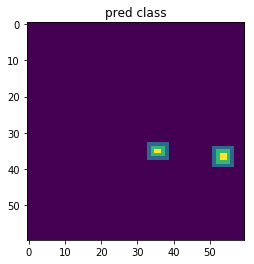

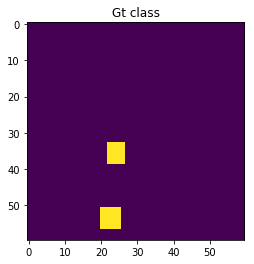

----------------------------------------------


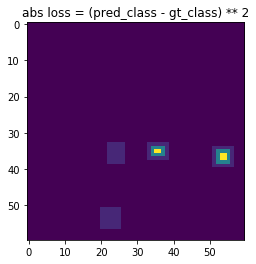

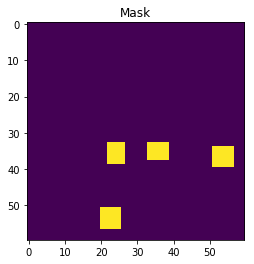

----------------------------------------------


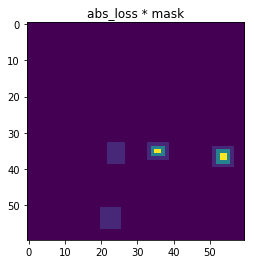

..
----------------------------------------------------------------------
Ran 2 tests in 3.381s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [3]:
import unittest
from unittest import TestSuite
from dataset import SquaresDataset
import matplotlib.pyplot as plt
import chainer.functions as F
from scipy import ndimage
from skimage.transform import rotate


class TestCode(unittest.TestCase):
    
    def test_dataset(self):
        """ TESTED: Test that datast works """
        # Basic plotting
        fig = plt.figure()
        fig.suptitle('Dataset generation example', fontsize=20)
        
        # Generate and visualize the dataset squares
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=60, img_w=60)
        db.visualize_batch(imgs, labels)
    
    def test_encode_y(self):
        """ TESTED: Manually worked out example with batch size of two. Trivial category. """
        # Encoded boxes in a couple of boxes should look like the distance transform
        fig = plt.figure()
        fig.suptitle('Encode y example', fontsize=20)
        
        # Let's try with random values first
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=60, img_w=60)
        gt_class, gt_loc = encode_y(imgs, labels)

        # Plot the encoded values
        plt.imshow(gt_loc[0,2,:,:])
        plt.show()
        
    def test_downsample(self):
        """ LOGIC: Test that shape matches. """
        # Basic plotting
        fig = plt.figure()
        fig.suptitle('Downsampling visual test', fontsize=20)
        
        # Let's generate some boxes
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=80, w=80, img_h=240, img_w=240)
        db.visualize_batch(imgs, labels)
        
        # Check that boxes redrawn after downsampling look identical to original ones
        imgs_down, labels_down = downsample(imgs, labels)
        db.visualize_batch(imgs_down, labels_down)
    
    def test_predict(self):
        """ LOGIC: What does this method do? """
        # Visualizing should also be fine
        
        # Do not implement for now. Only get the regression loss to work.
        pass
    
    def test_network(self):
        """ LOGIC: Test that the shape is correct? """
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        
        vgg = VGGNet()
        
        pred_loc, pred_class= vgg(imgs)
        print(' pred_loc shape :', pred_loc.shape)
        print(' pred_class shape :', pred_class.shape)
        
        # Need to add more tests here. Just checking for shape is not sufficient.
    
    def test_loss(self):
        """ LOGIC: Calculate sample loss for the network. Trivial category. """
        print(loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4))
        
        # Not really needed but let's still add a debug flag and check that this works
        pass
    
    def test_reg_loss(self):
        """ LOGIC: Calculate regression loss for the network with batch size of two. Trivial category. """
        # Shift by two pixels and check?
        # Basic plotting
        fig = plt.figure()
        fig.suptitle('Regression loss example', fontsize=20)
        
        # Should we show the regression loss hm here?
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        x_down, labels_down = downsample(imgs, labels)
        
        # Loss calculation
        pred_class, pred_loc = vgg(imgs)
        gt_class, gt_loc = encode_y(imgs, labels)
        reg_loss = regression_loss(pred_loc, gt_loc, gt_class)
        
        # Plot and print the final regression loss
    
    def test_class_loss(self):
        """ LOGIC: Calculate classification loss for the network with batch size of two. Trivial category. """
        # Should we show the classification loss heatmap here?
        # Shift by two pixels and check?
        fig = plt.figure()
        fig.suptitle('Classification loss example', fontsize=20)
        
        # Generate data
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        imgs_down, labels_down = downsample(imgs, labels)
        
        # Loss calculation
        vgg = VGGNet()
        pred_class, pred_loc = vgg(imgs)
        gt_class, gt_loc = encode_y(imgs_down, labels_down)
        
        class_loss = classification_loss(pred_class, gt_class)
        
        # Plot and print the final loss
        pass
    
    def test_classifier_learning_capacity(self):
        """ Is the network able to do any auxillary learning task properly """
        pass
    
    def test_convergence(self):
        """ Check that for the one and two squares datasets, the network loss convergence. Plot the loss and show that it converges. """
        
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        x_down, labels_down = downsample(imgs, labels)
        vgg = VGGNet()
        pred_class, pred_loc = vgg(imgs)
        gt_class, gt_loc = encode_y(imgs, labels)
        reg_loss = regression_loss(pred_loc, gt_loc, gt_class)
        total_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4)        

        pass
    
    def test_select_mask(self):
        """ For controlled inputs, check what the mask looks like. Does it look sensible? """
    
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        
        imgs_down, labels_down = downsample(imgs, labels)

        # Loss calculation
        gt_class, gt_loc = encode_y(imgs_down, labels_down)
        pred_class = gt_class.copy()

        pred_class[0,0,:,:] = rotate( ndimage.distance_transform_edt(gt_class[0,0,:,:]), 90)
        pred_class[1,0,:,:] = rotate(ndimage.distance_transform_edt(gt_class[1,0,:,:]), 90)

        plt.figure()
        plt.imshow(pred_class[0,0,:,:])
        plt.title('pred class')
        plt.show()

        plt.figure()
        plt.title('Gt class') 
        plt.imshow(gt_class[0,0,:,:]); plt.show()

        print('----------------------------------------------')
        #distance transform image
        for   i,image_class in enumerate(gt_class):

        # Absolute loss calculation
            abs_loss = (pred_class - gt_class) ** 2
            mask = selection_mask(abs_loss, gt_class)

        # Display the selection mask
        plt.figure()
        plt.imshow(abs_loss[0,0,:,:])
        plt.title('abs loss = (pred_class - gt_class) ** 2')
        plt.show()


        plt.figure()
        plt.title('Mask')
        plt.imshow(mask[0,0,:,:])
        plt.show()


        print('----------------------------------------------')

        plt.figure()
        plt.imshow(abs_loss[0,0,:,:]*mask[0,0,:,:])
        plt.title('abs_loss * mask')
        plt.show()

    
ts = TestSuite()
#ts.ad
ts.addTests([TestCode('test_select_mask'),TestCode('test_class_loss') ])
#ts.addTests([TestCode('test_encode_y'),
#             TestCode('test_downsample'),TestCode('test_network'),
#             TestCode('test_reg_loss'),TestCode('test_select_mask')  ])

unittest.TextTestRunner().run(ts)
#alltests = unittest.TestSuite([fast, slow])

In [1]:
db = SquaresDataset()
imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
imgs_down, labels_down = downsample(imgs, labels)
vgg = VGGNet()
pred_class, pred_loc = vgg(imgs)
gt_class, gt_loc = encode_y(imgs_down, labels_down)


reg_loss = regression_loss(pred_loc, gt_loc, gt_class)

class_loss = classification_loss(pred_class, gt_class)
        
total_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4) 


# pred_loc.shape, gt_loc.shape

NameError: name 'SquaresDataset' is not defined